In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import json
import os

In [2]:
def createfig(nrows=2,figsize=(8,5),nraxs=2,hspace=0.6):
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(nrows=nrows, ncols=1, hspace=hspace)
    axs = [0]*nraxs
    
    for i in range(len(axs)):
        axs[i] = fig.add_subplot(gs[i])
    return fig,axs


def get_params_metrics(experiment):
    """
    Input: Name of the folder with the Experiment
    Returns: Parameter and Metric file 
    """
    basepath = f'../saves/{experiment}'
    
    with open(f'{basepath}/params.json') as paramfile:
        params = json.load(paramfile)

    with open(f'{basepath}/metrics.json') as metricfile:
        metrics = json.load(metricfile)
        
    return params,metrics

def plot_metric(ax,experiment,metric='Average Hungarian Precision',color='Royalblue',title=True,legend=False,errors=True,label=None,yscale=True):
    p,m = get_params_metrics(experiment)
    
    x = np.arange(0,round(p['steps']/p['timestepsize']),p['sampling_rate']*p['timestepsize'])
    y = np.array(m[metric])
    
    ax.plot(x,y,label=label,color=color)
    ax.set_xlabel('Time')
    
    metric_error = metric.replace('Average','Var')
    
    if errors:
        error = 1*np.array(m[metric_error])
        ax.fill_between(x,y-error,y+error,alpha=0.5,color=color)
    
    if legend:
        ax.legend()
        
    if title:
        header = get_header(experiment)
        ax.set_title(header)
        
    if yscale:
        ax.set_ylim(0,1.1)
    
    return None


def get_header(exp):
    """
    Input: Folder Name of the Experiment
    Returns: The Title including the Experiment Parameters
    """
    s = exp.split('_')
    obs_axis = s[0]
    nr_agents = s[1]
    nr_ensembles = s[2]
    obs_noise = s[3]
    sampling_rate = s[4]
    
    if obs_axis == '110':
        obs_axis='Only Positions'
    elif obs_axis == '111':
        obs_axis = 'Positions & Momenta'
    
    title = f"Observed: {obs_axis}, Agents:{nr_agents}, Ensembles:{nr_ensembles},\n Obs. Noise:{obs_noise}, Sampling Rate:{sampling_rate}"
    return title

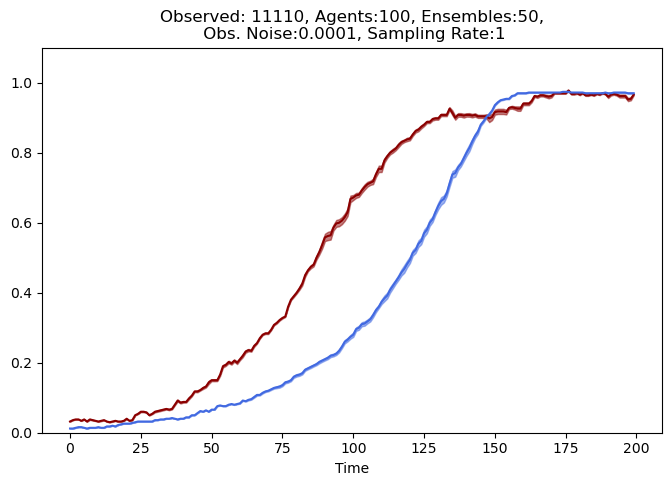

In [33]:
# Single Case Example for one Experiment

experiment = '11110_100_50_0.0001_1'

fig,axs = createfig(nrows=1,nraxs=1)

plot_metric(axs[0],experiment,color='darkred')
plot_metric(axs[0],experiment,'Average LPP')

In [17]:
def get_experiments(path):
    """
    Input: Path of the Saves Folder
    Output: A list of all Experiment names
    """
    
    experiments = os.listdir(path)

    removes = ['Baseline','.DS_Store','animations']

    for rem in removes:
        try:
            experiments.remove(rem)
        except:
            None
        
    return experiments

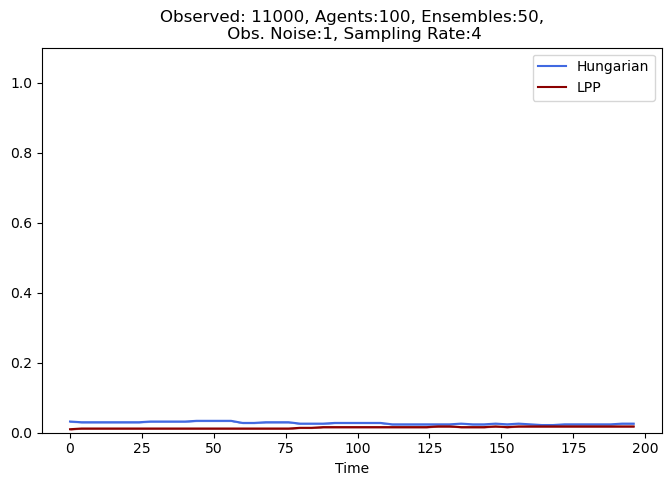

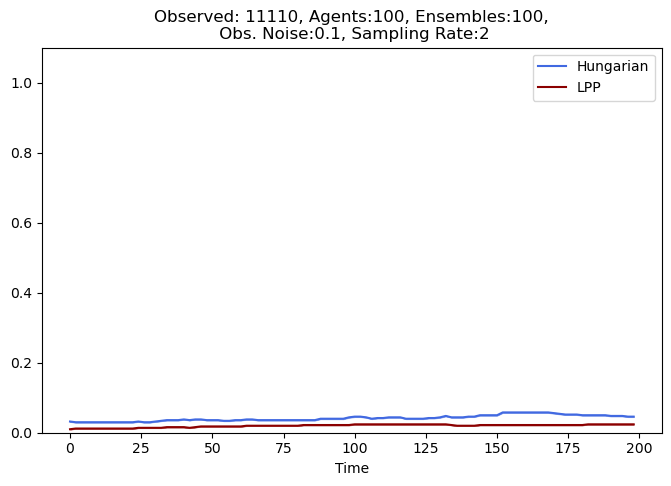

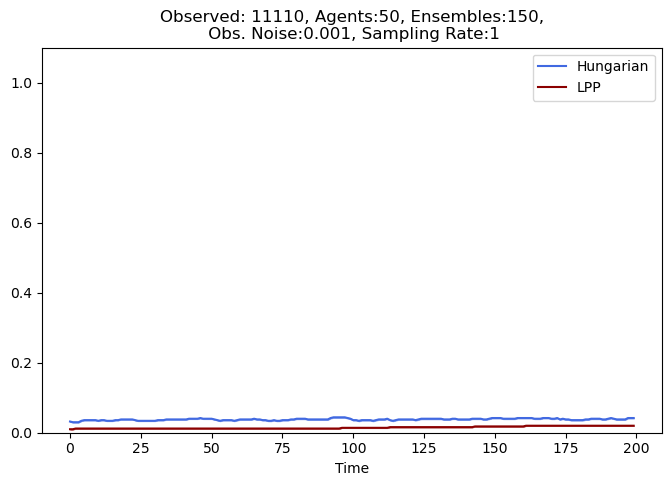

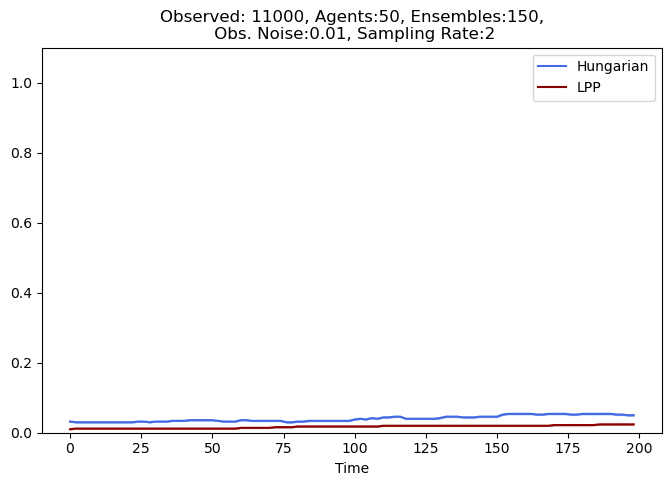

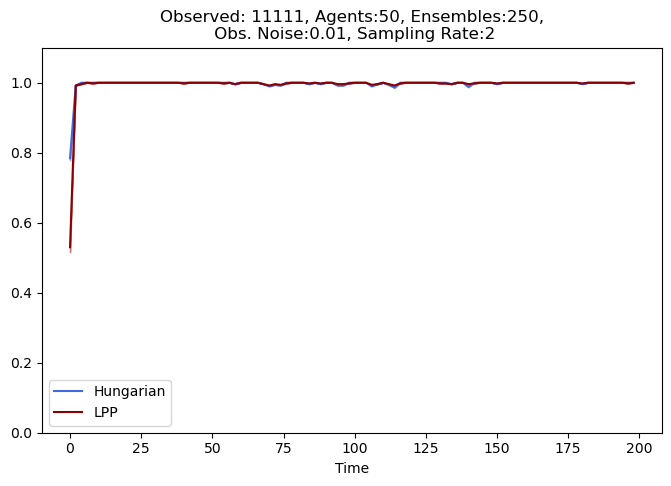

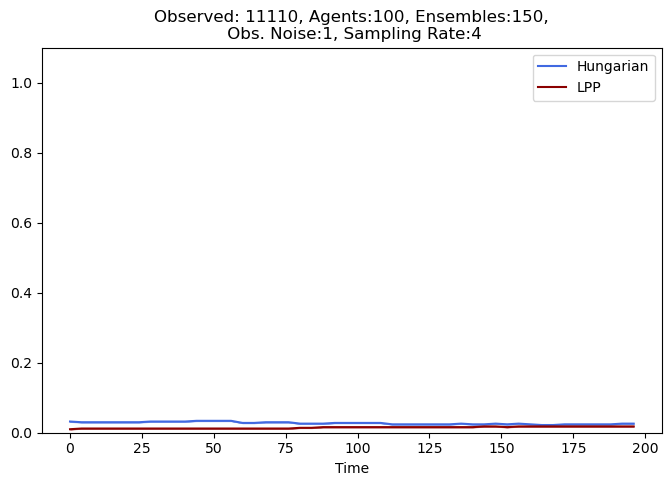

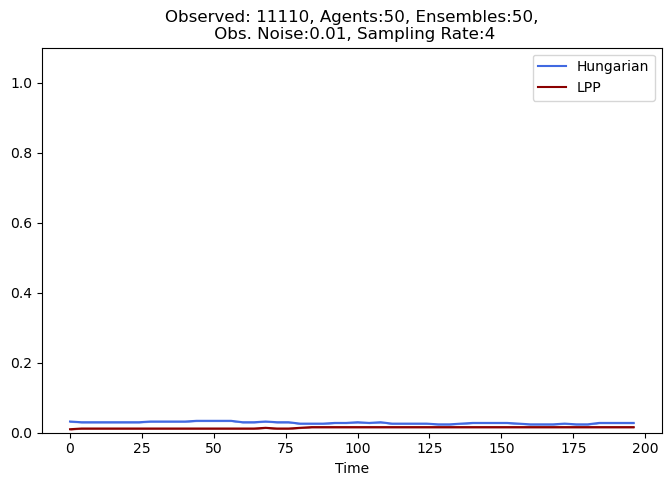

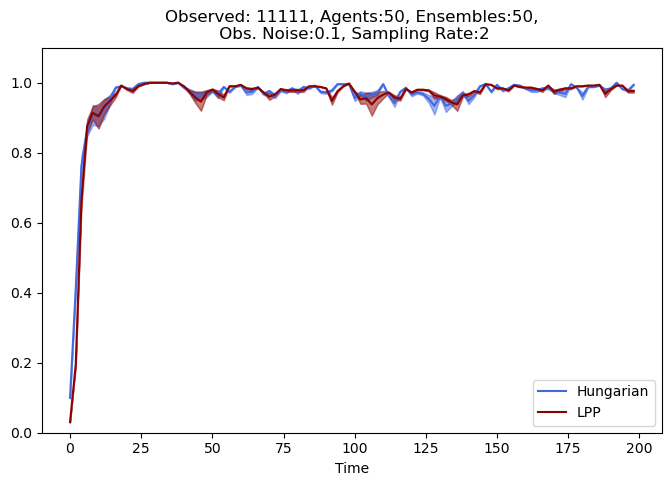

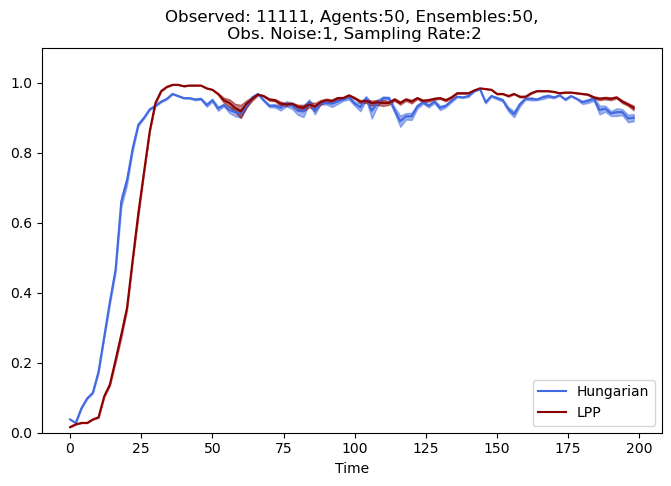

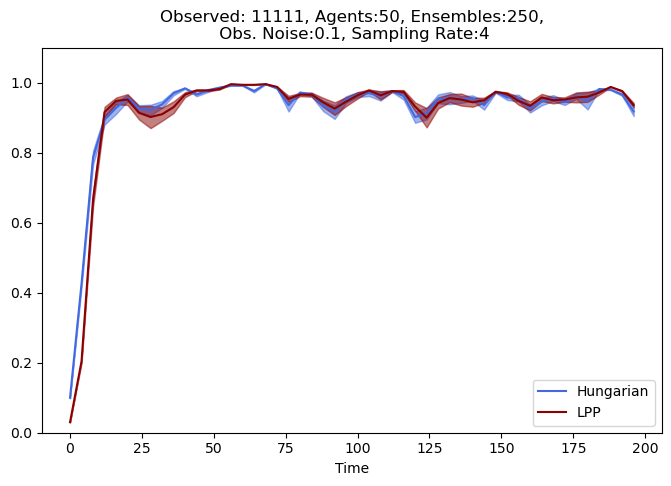

In [18]:
experiments = get_experiments('../saves/')

for exp in experiments[50:60]:
    
    fig,axs = createfig(nrows=1,nraxs=1)

    plot_metric(axs[0],exp,label='Hungarian',legend=True)
    plot_metric(axs[0],exp,'Average LPP',legend=True,color='darkred',label='LPP')
    del fig,axs

In [19]:
def get_avg_metric(experiment,metric='Average Hungarian Precision'):
    """
    Input: Experiment (folder name) and Metric (Hungarian or LPP)
    Output: Mean Precision starting at Timestep 176
    """
    p,m = get_params_metrics(experiment)
    
    x = np.arange(0,round(p['steps']/p['timestepsize']),p['sampling_rate']*p['timestepsize'])
    y = np.array(m[metric])
    avg_metric = np.mean(y[list(x).index(176):])
    
    return avg_metric

In [20]:
# The Parameter Ranges by Simon 
#(we should eventually put this into a File I guess and both read from it)
test_agents = [50,100]
test_ensembles = [50,100,150,200,250]
test_observation_noise = [0.0001 ,0.001, 0.01, 0.1, 1]
test_sampling_rate = [1,2,4]

In [21]:
def get_M(agents='100',obs='110',spl_rate='2'):
    """
    Input: Number of Agents, Sampling Rate and Observed Axis
    Output: Matrix for Imshow. X-Axis: Ensemble Size, Y-Axis: Measurement Noise, Color: Mean Precision
    """
    
    M = np.zeros([len(test_observation_noise),len(test_ensembles)])

    for i,nr_ensemble in enumerate(test_ensembles):

        for j,noise in enumerate(test_observation_noise):

            exp = f"{obs}_{agents}_{nr_ensemble}_{noise}_{spl_rate}"    

            h = get_avg_metric(exp)
            M[len(test_observation_noise)-1-j,i] = h


    return M 

In [22]:
def plot_M(ax,axcb,M,agents='100',obs='110',spl_rate='2'):
    """
    Input: Axis for plotting and for the colorbar, Matrix to be plotted
    """
    
    x1 = np.min(test_ensembles)-((test_ensembles[-1]-test_ensembles[-2])/2)
    x2 = np.max(test_ensembles)+((test_ensembles[-1]-test_ensembles[-2])/2)
    y1 = 1.125*np.log10(0.0001)
    y2 = 0.5
    
    show=ax.imshow(M,aspect='auto',cmap='RdBu',vmin=0,vmax=1,extent=(x1,x2,y1,y2))

    ax.set_xlabel('Kalman Ensemble Size')
    ax.set_xticks(test_ensembles)

    ax.set_ylabel('Observation Noise (Log10)')
    ax.set_yticks(np.log10(test_observation_noise))
    
    ax.set_title(f'Agents: {agents}, Sampling Rate: {spl_rate}',size=10)


    axcb.axis('off')
    cbar = fig.colorbar(show,ax=axcb,orientation='vertical',location='right',fraction=1)
    cbar.set_ticks([0,0.25,0.5,0.75,1])
    return None

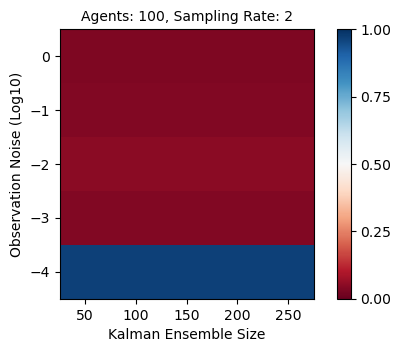

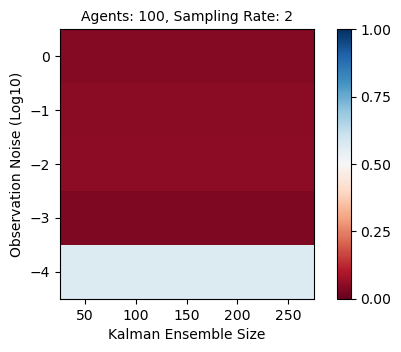

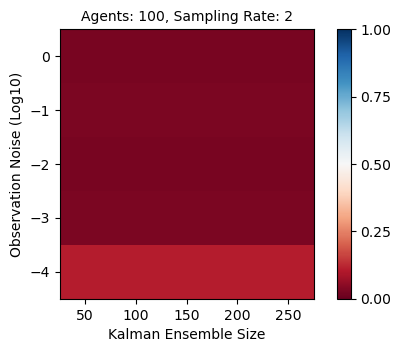

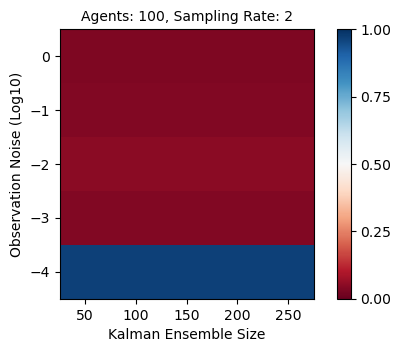

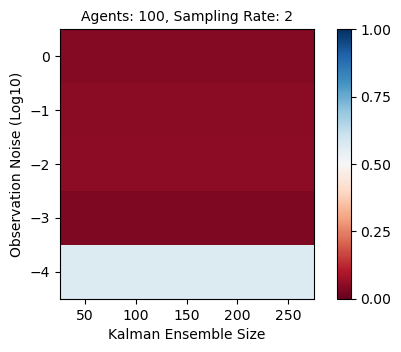

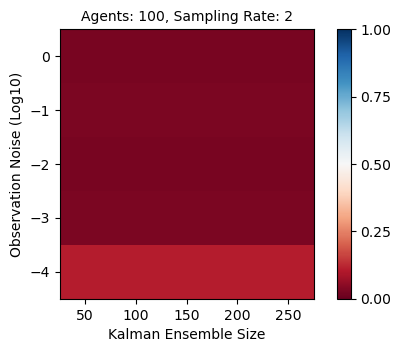

In [24]:
for agents in test_agents:
    for spl_rate in test_sampling_rate:

        M = get_M(agents,'11110',spl_rate)

        fig = plt.figure(figsize=(4.4,3.5))
        gs = gridspec.GridSpec(nrows=1, ncols=2, wspace=0.15, width_ratios=[4,1])
        axs = [0]*2
        for i in range(len(axs)):
            axs[i] = fig.add_subplot(gs[i])

        plot_M(axs[0],axs[1],M)
        